### [Only In Google Colab] Setup TiRex in Colab

Make sure that you selected a **GPU runtime in Google Colab**
Runtime ->  Change Runtime Type -> Select A100 / L4 / T4

In [2]:
# Only for Google Colab Notebook!

import os

# Clone TiRep Repo
!git clone https://github.com/NX-AI/tirex

# Install TiRex
os.chdir('/content/tirex')
!pip install .[gluonts]

# Set Workin Dir to notebooks folder
os.chdir('/content/tirex/examples')

Cloning into 'tirex'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 50 (delta 5), reused 2 (delta 2), pack-reused 29 (from 1)
Receiving objects: 100% (50/50), 57.43 KiB | 14.36 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Processing /content/tirex
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Imports and Load Data

In [3]:
from pathlib import Path

import numpy as np
import torch
from util_plot import plot_fc

# import os
# os.environ["TIREX_NO_CUDA"] = "1"   # Experimental!!: Turns off sLSTM CUDA kernels if you have problems but be aware of the downsides! (see repository FAQ)
from tirex import ForecastModel, load_model

# Load Example Data
ctx_s, future_s = np.split(np.genfromtxt(Path.cwd() / "air_passengers.csv"), [-12])
ctx_l, future_l = np.split(np.genfromtxt(Path.cwd() / "loop_seattle_5T_example.csv"), [-512])

In [1]:
ctx_l

NameError: name 'ctx_l' is not defined

### TiRex Forecast in 2 Lines

1) Load Model
2) Generate Forecast

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.ckpt:   0%|          | 0.00/141M [00:00<?, ?B/s]

Using /root/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py311_cu124/slstm_HS512BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py311_cu124/slstm_HS512BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0/build.ninja...
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module slstm_HS512BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module slstm_HS512BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
/usr/local/lib/python3.11/di

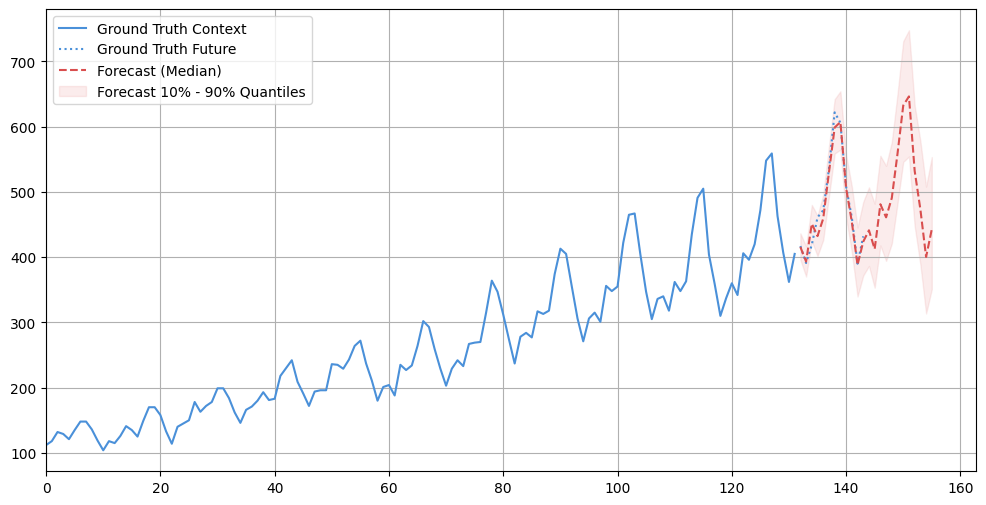

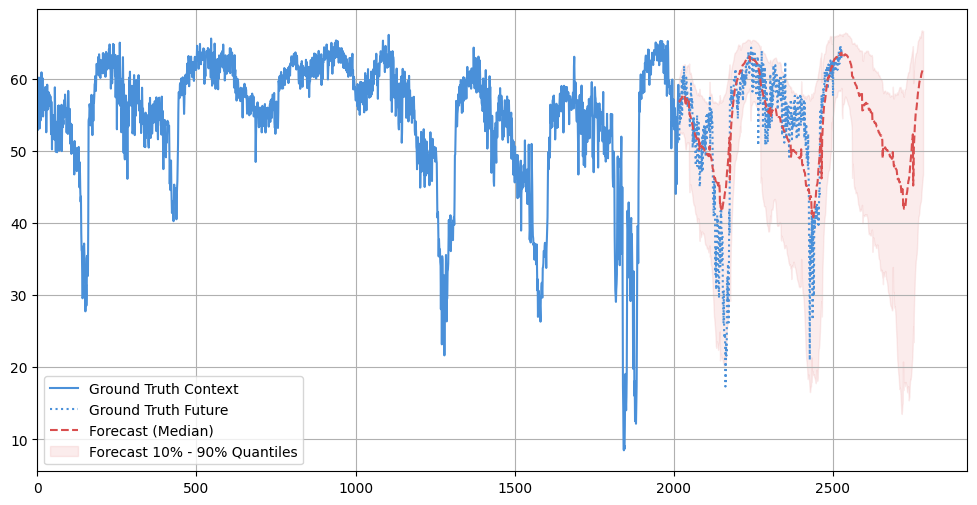

In [4]:
# 1) Load Model
model: ForecastModel = load_model("NX-AI/TiRex")

# 2) Short Horizon - Example
quantiles, mean = model.forecast(ctx_s, prediction_length=24)
plot_fc(ctx_s, quantiles[0], future_s)

# 2) Long Horizon - Example
quantiles, mean = model.forecast(ctx_l, prediction_length=768)
plot_fc(ctx_l, quantiles[0], future_l)

### Input Options

TiRex supports forecasting with different input types

In [5]:
data = torch.tensor(np.genfromtxt(Path.cwd() / "air_passengers.csv"))  # Load Example

# Torch tensor (2D or 1D)
quantiles, means = model.forecast(context=data, prediction_length=24)
print("Predictions (Torch tensor):\n", type(quantiles), quantiles.shape)

# List of Torch tensors (List of 1D) - will be padded
list_torch_data = [data, data, data]
quantiles, means = model.forecast(context=list_torch_data, prediction_length=24, batch_size=2)
print("Predictions (List of Torch tensors):\n", type(quantiles), quantiles.shape)

# NumPy array (2D or 1D)
quantiles, means = model.forecast(context=data.numpy(), prediction_length=24, output_type="torch")
print("Predictions (NumPy):\n", type(quantiles), quantiles.shape)


# List of NumPy arrays (List of 1D) - will be padded
list_numpy_data = [data.numpy()]  # Split into 3 sequences
quantiles, means = model.forecast(context=list_numpy_data, prediction_length=24)
print("Predictions (List of NumPy arrays):\n", type(quantiles), quantiles.shape)


# GluonTS Dataset
try:
    from typing import cast

    from gluonts.dataset import Dataset

    gluon_dataset = cast(Dataset, [{"target": data, "item_id": 1}, {"target": data, "item_id": 22}])
    quantiles, means = model.forecast_gluon(gluon_dataset, prediction_length=24)
    print("Predictions GluonDataset:\n", type(quantiles), quantiles.shape)
    # If you use also `glutonts` as your output type the start_time and item_id get preserved accordingly
    predictions_gluon = model.forecast_gluon(gluon_dataset, prediction_length=24, output_type="gluonts")
    print("Predictions GluonDataset:\n", type(predictions_gluon), type(predictions_gluon[0]))
except Exception as e:
    print(e)
    # To use the gluonts function you need to install the optional dependency
    # pip install tirex[gluonts]
    pass

Predictions (Torch tensor):
 <class 'torch.Tensor'> torch.Size([1, 24, 9])
Predictions (List of Torch tensors):
 <class 'torch.Tensor'> torch.Size([3, 24, 9])
Predictions (NumPy):
 <class 'torch.Tensor'> torch.Size([1, 24, 9])
Predictions (List of NumPy arrays):
 <class 'torch.Tensor'> torch.Size([1, 24, 9])
Predictions GluonDataset:
 <class 'torch.Tensor'> torch.Size([2, 24, 9])
Predictions GluonDataset:
 <class 'list'> <class 'gluonts.model.forecast.QuantileForecast'>


### Output Options


TiRex supports different output types for the forecasts

Predictions:
 <class 'torch.Tensor'> torch.Size([1, 24, 9])
Predictions:
 <class 'numpy.ndarray'> (1, 24, 9)
Predictions batch 0:
 <class 'torch.Tensor'> torch.Size([2, 32, 9])
Predictions batch 1:
 <class 'torch.Tensor'> torch.Size([2, 32, 9])
Predictions batch 2:
 <class 'torch.Tensor'> torch.Size([1, 32, 9])
Predictions (GluonTS Quantile Forecast):
 <class 'list'> <class 'gluonts.model.forecast.QuantileForecast'>


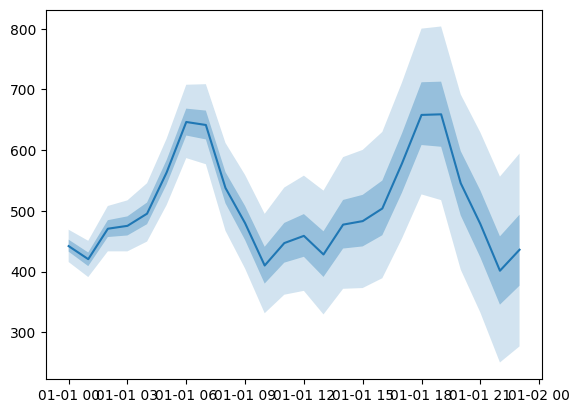

In [6]:
data = torch.tensor(np.genfromtxt(Path.cwd() / "air_passengers.csv"))  # Load Example

# Default: 2D Torch tensor
quantiles, means = model.forecast(context=data, prediction_length=24, output_type="torch")
print("Predictions:\n", type(quantiles), quantiles.shape)


# 2D Numpy Array
quantiles, means = model.forecast(context=data, prediction_length=24, output_type="numpy")
print("Predictions:\n", type(quantiles), quantiles.shape)


# Iterate by patch
# You can also use the forecast function as iterable. This might help with big datasets. All output_types are supported
for i, fc_batch in enumerate(
    model.forecast(context=[data, data, data, data, data], batch_size=2, output_type="torch", yield_per_batch=True)
):
    quantiles, means = fc_batch
    print(f"Predictions batch {i}:\n", type(quantiles), quantiles.shape)


try:
    # QuantileForecast (GluonTS)
    predictions_gluonts = model.forecast(context=data, prediction_length=24, output_type="gluonts")
    print("Predictions (GluonTS Quantile Forecast):\n", type(predictions_gluon), type(predictions_gluon[0]))
    predictions_gluonts[0].plot()
except Exception as e:
    print(e)
    # To use the gluonts function you need to install the optional dependency
    # pip install tirex[gluonts]

In [7]:
from google.colab import files

uploaded = files.upload()

Saving TEST Forecasting - AI.xlsx to TEST Forecasting - AI.xlsx


In [35]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tirex import ForecastModel, load_model
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions
from gluonts.dataset.util import to_pandas

print("Libraries loaded. Starting data processing...")



Libraries loaded. Starting data processing...


In [23]:
df_a = pd.read_excel("TEST Forecasting - AI.xlsx", sheet_name=["Artikel A"])

In [24]:
df_a

{'Artikel A':          Termin  Menge
 0    2017-01-10    760
 1    2017-01-25     80
 2    2017-01-30    500
 3    2017-01-31     27
 4    2017-02-01     50
 ...         ...    ...
 1998 2025-07-25     30
 1999 2025-07-28    181
 2000 2025-07-29    185
 2001 2025-07-30     80
 2002 2025-08-01     25
 
 [2003 rows x 2 columns]}

In [22]:
df_a1 = pd.read_excel()
df_a1
#df_a2 = pd.read_csv(df_a["Artikel B"])
#df_a3 = pd.read_csv(df_a["Artikel C"])

KeyError: 'Artikel A'

In [25]:
# Load the three CSV files into pandas DataFrames

try:
    df_a = pd.read_excel("TEST Forecasting - AI.xlsx", sheet_name=["Artikel A"])
    df_b = pd.read_excel("TEST Forecasting - AI.xlsx", sheet_name=["Artikel B"])
    df_c = pd.read_excel("TEST Forecasting - AI.xlsx", sheet_name=["Artikel C"])
    print("All three CSV files loaded successfully.")
except FileNotFoundError:
    print("Error: One or more of the CSV files were not found. Please ensure they are in the same directory as this notebook.")
    # Exit or handle the error gracefully
except Exception as e:
    print(f"An error occurred while loading the files: {e}")
    # Exit or handle the error gracefully

# Clean and standardize the dataframes
def preprocess_df(df, name):
    """
    Standardizes column names, converts the date column to datetime objects,
    sets the date as the index, and resamples to a daily frequency, filling missing days with 0.
    """
    print(f"\nPreprocessing data for {name}...")
    # Standardize column names
    df.columns = ["date", "value"]

    # Convert date column to datetime
    df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

    # Set the date as the index
    df = df.set_index("date")

    # Resample to a daily frequency and fill missing days with 0
    df = df.asfreq('D', fill_value=0)

    print(f"Preprocessing for {name} complete. Data shape: {df.shape}")
    return df



All three CSV files loaded successfully.


In [26]:
df_a = preprocess_df(df_a, "Artikel A")



Preprocessing data for Artikel A...


AttributeError: 'dict' object has no attribute 'columns'

In [ ]:
df_b = preprocess_df(df_b, "Artikel B")


In [ ]:
df_c = preprocess_df(df_c, "Artikel C")



In [27]:
# Store dataframes and their names in a dictionary for easy iteration
datasets = {
    "Artikel A": df_a,
    "Artikel B": df_b,
    "Artikel C": df_c,
}

In [28]:
datasets

{'Artikel A': {'Artikel A':          Termin  Menge
  0    2017-01-10    760
  1    2017-01-25     80
  2    2017-01-30    500
  3    2017-01-31     27
  4    2017-02-01     50
  ...         ...    ...
  1998 2025-07-25     30
  1999 2025-07-28    181
  2000 2025-07-29    185
  2001 2025-07-30     80
  2002 2025-08-01     25
  
  [2003 rows x 2 columns]},
 'Artikel B': {'Artikel B':          Termin  Menge
  0    2017-01-10     40
  1    2017-01-20     20
  2    2017-01-30     62
  3    2017-01-31      5
  4    2017-02-01    140
  ...         ...    ...
  1854 2025-07-21    120
  1855 2025-07-23     83
  1856 2025-07-24     30
  1857 2025-07-25     24
  1858 2025-07-28    112
  
  [1859 rows x 2 columns]},
 'Artikel C': {'Artikel C':     Wunschtermin  Menge
  0     2018-11-08     54
  1     2018-11-12     24
  2     2018-11-13      9
  3     2018-11-21     59
  4     2018-11-28     45
  ..           ...    ...
  698   2025-07-17      9
  699   2025-07-22     90
  700   2025-07-23     18


In [29]:
try:
    excel_file = "TEST Forecasting - AI.xlsx"
    all_sheets = pd.read_excel(excel_file, sheet_name=None)
    print(f"All sheets from '{excel_file}' loaded successfully.")
except FileNotFoundError:
    print(f"Error: The Excel file '{excel_file}' was not found. Please ensure it is in the same directory as this notebook.")
    # Exit or handle the error gracefully
    all_sheets = {}
except Exception as e:
    print(f"An error occurred while loading the Excel file: {e}")
    # Exit or handle the error gracefully
    all_sheets = {}

# Dictionary to map German column names to English
column_name_translation = {
    "Termin": "date",
    "Wunschtermin": "date",
    "Menge": "value"
}

def preprocess_df(df, name):
    """
    Standardizes column names based on a translation map, converts the date column
    to datetime objects, sets the date as the index, and resamples to a daily
    frequency, filling missing days with 0.
    """
    print(f"\nPreprocessing data for sheet: {name}...")

    # Translate and standardize column names
    df.rename(columns=column_name_translation, inplace=True)

    # Check if the required columns exist after renaming
    if "date" not in df.columns or "value" not in df.columns:
        print(f"Error: Missing 'date' or 'value' column after renaming for sheet '{name}'. Skipping.")
        return None

    # Convert date column to datetime
    df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

    # Set the date as the index
    df = df.set_index("date")

    # Resample to a daily frequency and fill missing days with 0
    df = df.asfreq('D', fill_value=0)

    print(f"Preprocessing for '{name}' complete. Data shape: {df.shape}")
    return df

# Create a new dictionary to store the preprocessed dataframes
datasets = {}
if all_sheets:
    for name, df in all_sheets.items():
        preprocessed_df = preprocess_df(df, name)
        if preprocessed_df is not None:
            datasets[name] = preprocessed_df

print("\nDatasets dictionary created with preprocessed data.")


All sheets from 'TEST Forecasting - AI.xlsx' loaded successfully.

Preprocessing data for sheet: Artikel A...
Preprocessing for 'Artikel A' complete. Data shape: (3126, 1)

Preprocessing data for sheet: Artikel B...
Preprocessing for 'Artikel B' complete. Data shape: (3122, 1)

Preprocessing data for sheet: Artikel C...
Preprocessing for 'Artikel C' complete. Data shape: (2455, 1)

Datasets dictionary created with preprocessed data.



Executing forecasting scenarios for: Artikel A

--- Scenario 1: Long-term forecasting ---

--- Evaluation for Artikel A - Long-term Forecast (Predicting year 2025) ---
Mean Absolute Error (MAE): 108.03
Root Mean Squared Error (RMSE): 257.70
Mean Absolute Percentage Error (MAPE): 0.00%


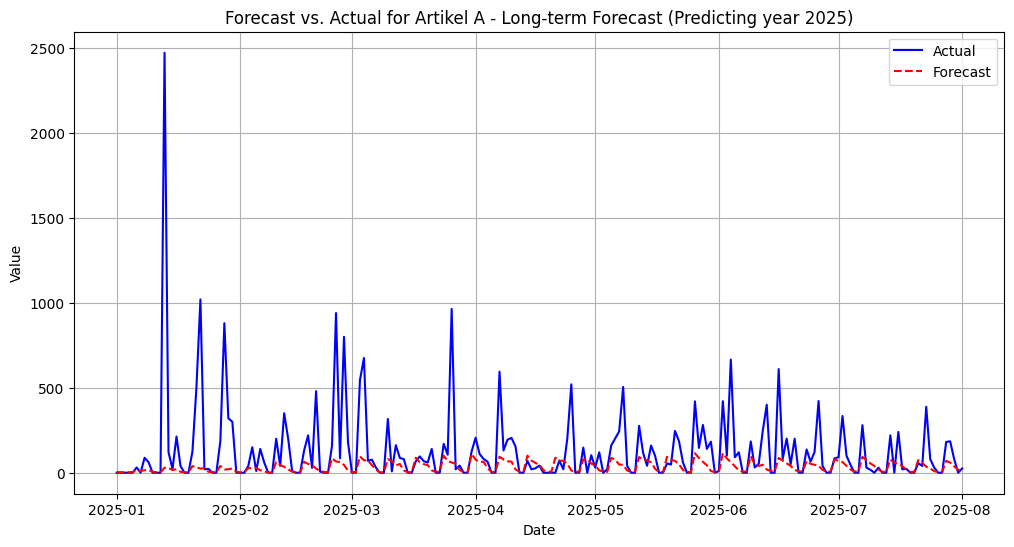


--- Scenario 2: Short-term forecasting ---
Not enough data to create a quarterly split. Skipping.

--- Scenario 3: Backtesting (Rolling Window) ---


/tmp/ipython-input-864886472.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted[predicted < 0] = 0



--- Evaluation for Artikel A - Rolling Window Backtesting ---
Mean Absolute Error (MAE): 74.96
Root Mean Squared Error (RMSE): 181.07
Mean Absolute Percentage Error (MAPE): 0.00%


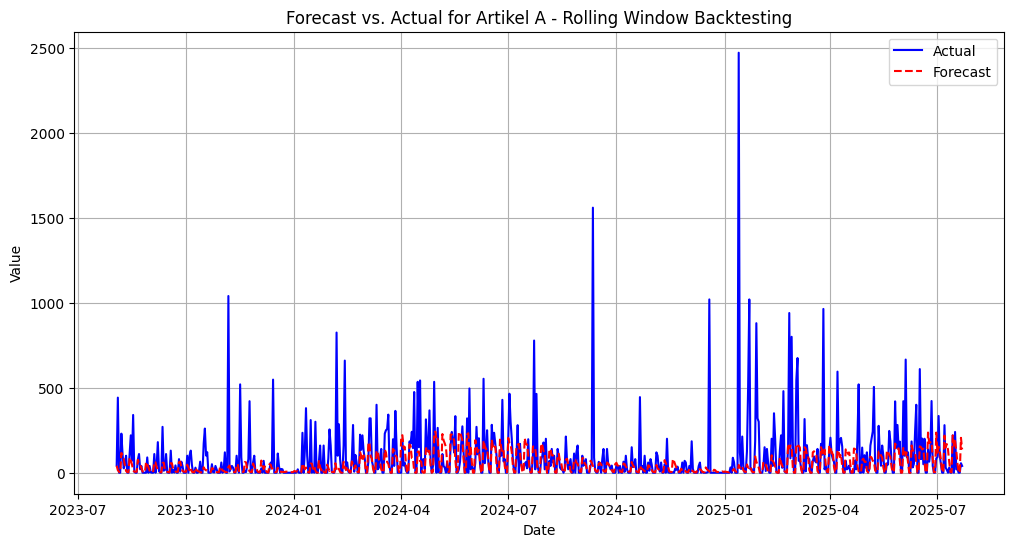


Executing forecasting scenarios for: Artikel B


/usr/local/lib/python3.11/dist-packages/xlstm/blocks/slstm/cell.py:543: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @conditional_decorator(
/usr/local/lib/python3.11/dist-packages/xlstm/blocks/slstm/cell.py:568: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @conditional_decorator(



--- Scenario 1: Long-term forecasting ---

--- Evaluation for Artikel B - Long-term Forecast (Predicting year 2025) ---
Mean Absolute Error (MAE): 44.28
Root Mean Squared Error (RMSE): 96.43
Mean Absolute Percentage Error (MAPE): 0.00%


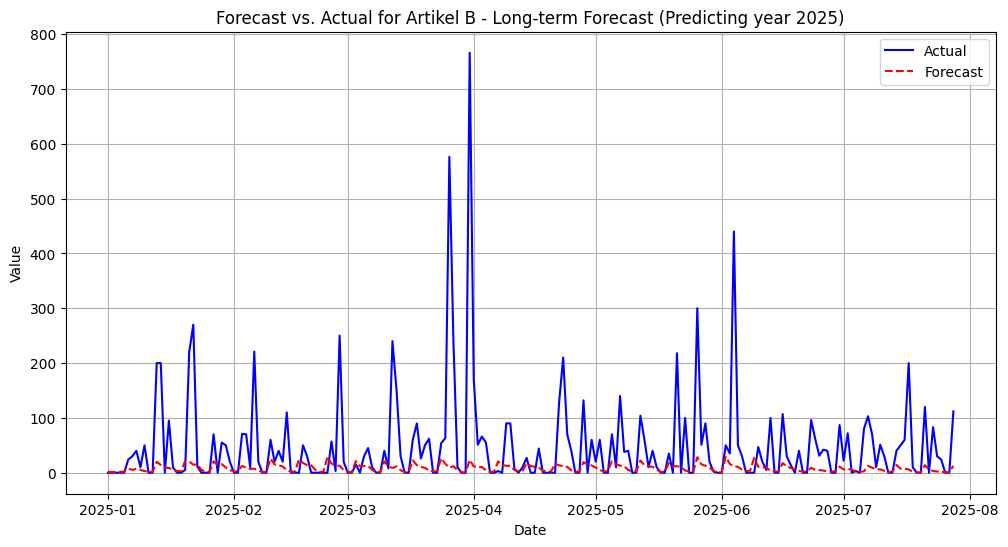


--- Scenario 2: Short-term forecasting ---
Not enough data to create a quarterly split. Skipping.

--- Scenario 3: Backtesting (Rolling Window) ---

--- Evaluation for Artikel B - Rolling Window Backtesting ---
Mean Absolute Error (MAE): 35.96
Root Mean Squared Error (RMSE): 158.01
Mean Absolute Percentage Error (MAPE): 0.00%


/tmp/ipython-input-864886472.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted[predicted < 0] = 0


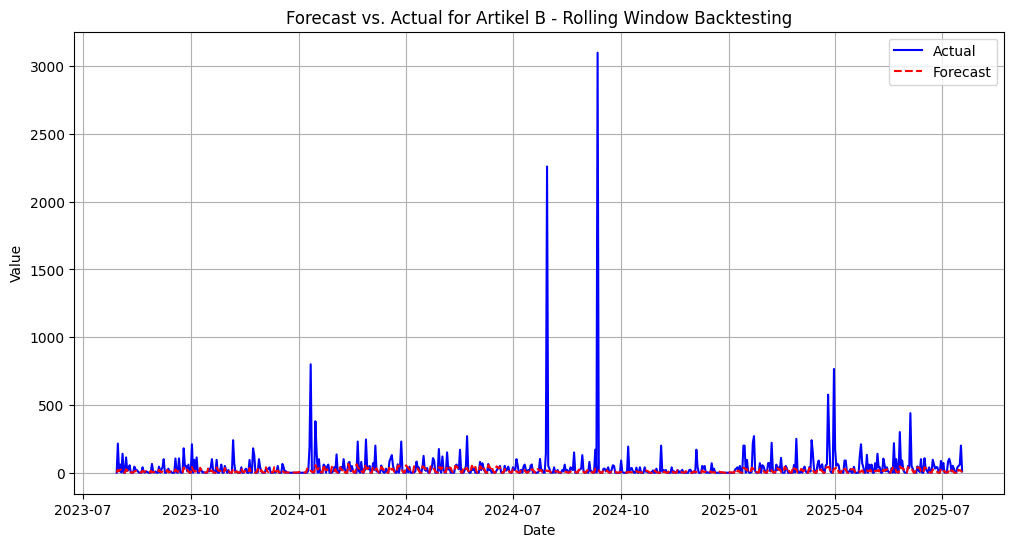


Executing forecasting scenarios for: Artikel C


/usr/local/lib/python3.11/dist-packages/xlstm/blocks/slstm/cell.py:543: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @conditional_decorator(
/usr/local/lib/python3.11/dist-packages/xlstm/blocks/slstm/cell.py:568: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @conditional_decorator(



--- Scenario 1: Long-term forecasting ---

--- Evaluation for Artikel C - Long-term Forecast (Predicting year 2025) ---
Mean Absolute Error (MAE): 16.93
Root Mean Squared Error (RMSE): 70.08
Mean Absolute Percentage Error (MAPE): 0.00%


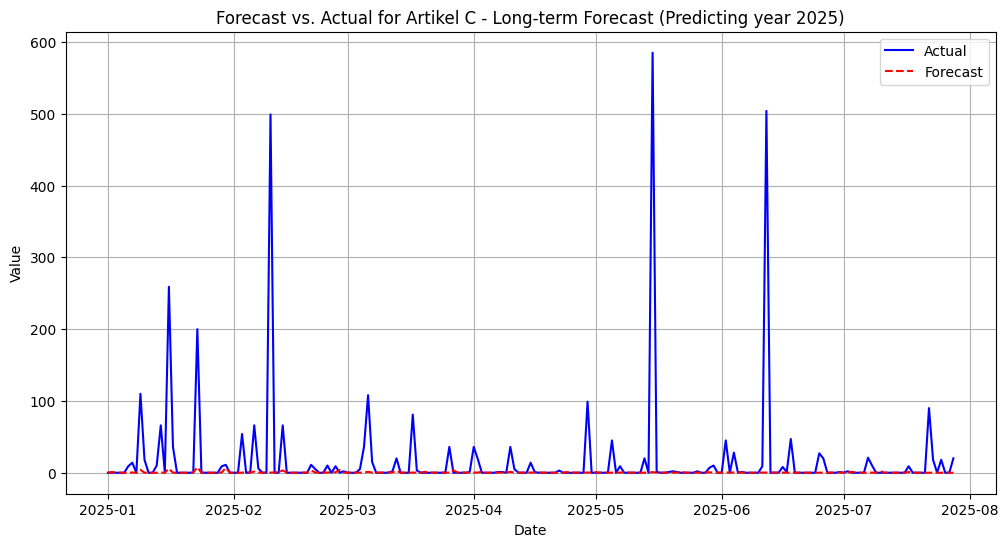


--- Scenario 2: Short-term forecasting ---
Not enough data to create a quarterly split. Skipping.

--- Scenario 3: Backtesting (Rolling Window) ---

--- Evaluation for Artikel C - Rolling Window Backtesting ---
Mean Absolute Error (MAE): 15.19
Root Mean Squared Error (RMSE): 65.68
Mean Absolute Percentage Error (MAPE): 0.00%


/tmp/ipython-input-864886472.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted[predicted < 0] = 0


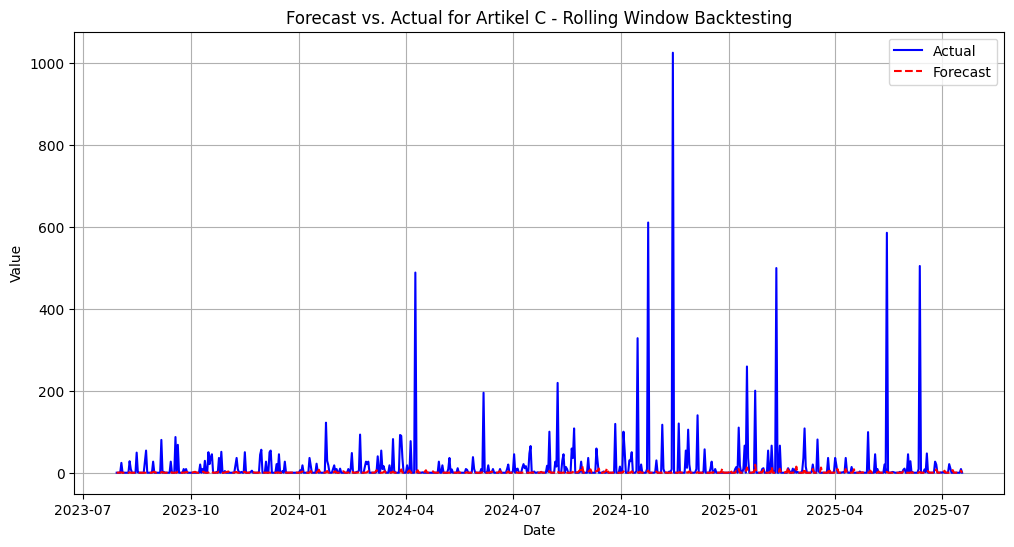


All datasets and scenarios have been processed.


In [37]:
# Dictionary to store evaluation results for a final summary
evaluation_results = {}

def evaluate_model(actual, predicted, title):
    """
    Calculates and prints evaluation metrics, and plots the forecast.

    Args:
        actual (pd.Series): The actual values.
        predicted (pd.Series): The predicted values.
        title (str): The title for the evaluation report and plot.

    Returns:
        dict: A dictionary containing the calculated metrics.
    """
    # Ensure predicted values are non-negative
    predicted[predicted < 0] = 0

    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    # MAPE calculation, handling division by zero
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    mape = mape if np.isfinite(mape) else 0.0

    print(f"\n--- Evaluation for {title} ---")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(actual.index, actual, label="Actual", color="blue")
    plt.plot(predicted.index, predicted, label="Forecast", color="red", linestyle="--")
    plt.title(f"Forecast vs. Actual for {title}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}


# Main loop to process each dataset and run scenarios
for name, data in datasets.items():
    print("\n" + "="*80)
    print(f"Executing forecasting scenarios for: {name}")
    print("="*80)

    # Initialize a temporary dictionary for this dataset's results
    evaluation_results[name] = {}

    # Load the model once for each dataset using the correct path
    model = load_model("NX-AI/TiRex")

    # --------------------------------------------------------------------------
    # Scenario 1: Long-term forecast (3 years of training, predict 4th year)
    # --------------------------------------------------------------------------
    print("\n--- Scenario 1: Long-term forecasting ---")

    end_date = data.index.max()
    last_year = end_date.year

    train_end = f"{last_year-1}-12-31"
    test_start = f"{last_year}-01-01"

    if pd.to_datetime(train_end) < data.index.min() or pd.to_datetime(test_start) > data.index.max():
        print("Not enough data for this scenario. Skipping.")
    else:
        train_data = data.loc[:train_end]
        test_data = data.loc[test_start:]

        if test_data.empty:
            print("Not enough data to create a test set for the last year. Skipping.")
        else:
            prediction_length_long = len(test_data)

            # Use the correct data format for the tirex model
            context = [train_data["value"].values]

            # Use "numpy" as the output type and extract the mean
            quantiles, means = model.forecast(
                context=context,
                prediction_length=prediction_length_long,
                output_type="numpy"
            )

            # Create a pandas Series from the numpy array with the correct date index
            forecast_mean = pd.Series(means.flatten(), index=test_data.index)

            metrics = evaluate_model(test_data["value"], forecast_mean, f"{name} - Long-term Forecast (Predicting year {last_year})")
            evaluation_results[name]["long_term"] = metrics


    # --------------------------------------------------------------------------
    # Scenario 2: Short-term forecast (3 quarters of training, predict 4th)
    # --------------------------------------------------------------------------
    print("\n--- Scenario 2: Short-term forecasting ---")

    last_year = data.index.max().year

    q1_3_end = pd.to_datetime(f"{last_year}-09-30")
    q4_start = pd.to_datetime(f"{last_year}-10-01")

    if q1_3_end < data.index.min() or q4_start > data.index.max():
        print("Not enough data to create a quarterly split. Skipping.")
    else:
        train_data_q = data.loc[:q1_3_end]
        test_data_q = data.loc[q4_start:]

        if test_data_q.empty:
            print("Not enough data for the fourth quarter. Skipping.")
        else:
            prediction_length_short = len(test_data_q)

            # Use the correct data format for the tirex model
            context_q = [train_data_q["value"].values]

            # Use "numpy" as the output type and extract the mean
            quantiles_q, means_q = model.forecast(
                context=context_q,
                prediction_length=prediction_length_short,
                output_type="numpy"
            )

            # Create a pandas Series from the numpy array with the correct date index
            forecast_mean_q = pd.Series(means_q.flatten(), index=test_data_q.index)

            metrics = evaluate_model(test_data_q["value"], forecast_mean_q, f"{name} - Short-term Forecast (Predicting 4th quarter of {last_year})")
            evaluation_results[name]["short_term"] = metrics


    # --------------------------------------------------------------------------
    # Scenario 3: Backtesting / Rolling Window Validation
    # --------------------------------------------------------------------------
    print("\n--- Scenario 3: Backtesting (Rolling Window) ---")

    backtest_length = 365 * 2
    horizon = 30
    step = 30

    if len(data) < backtest_length + horizon:
        print("Not enough data for a meaningful backtesting scenario. Skipping.")
    else:
        start_index = len(data) - backtest_length
        end_index = len(data) - horizon

        actual_values = []
        predicted_values = []
        forecast_dates = []

        for i in range(start_index, end_index, step):
            train_slice = data.iloc[:i]
            test_slice = data.iloc[i : i + horizon]

            if test_slice.empty:
                continue

            # Use the correct data format for the tirex model
            context_backtest = [train_slice["value"].values]

            # Use "numpy" as the output type and extract the mean
            quantiles_backtest, means_backtest = model.forecast(
                context=context_backtest,
                prediction_length=horizon,
                output_type="numpy"
            )

            # Create a pandas Series from the numpy array with the correct date index
            forecast_mean_backtest = pd.Series(means_backtest.flatten(), index=test_slice.index)

            actual_values.append(test_slice["value"].values)
            predicted_values.append(forecast_mean_backtest.values)
            forecast_dates.extend(test_slice.index.tolist())

        if not actual_values or not predicted_values:
            print("Backtesting loop produced no data. Skipping evaluation.")
        else:
            all_actual = np.concatenate(actual_values)
            all_predicted = np.concatenate(predicted_values)

            all_predicted[all_predicted < 0] = 0

            results_df = pd.DataFrame({
                "actual": all_actual,
                "predicted": all_predicted,
            }, index=pd.to_datetime(forecast_dates)).sort_index()

            metrics = evaluate_model(results_df["actual"], results_df["predicted"], f"{name} - Rolling Window Backtesting")
            evaluation_results[name]["backtesting"] = metrics

print("\nAll datasets and scenarios have been processed.")


Executing forecasting scenarios for: Artikel A


/usr/local/lib/python3.11/dist-packages/xlstm/blocks/slstm/cell.py:543: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @conditional_decorator(
/usr/local/lib/python3.11/dist-packages/xlstm/blocks/slstm/cell.py:568: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @conditional_decorator(



--- Scenario 1: Long-term forecasting ---

--- Evaluation for Artikel A - Long-term Forecast (Predicting year 2025) ---
Mean Absolute Error (MAE): 108.03
Root Mean Squared Error (RMSE): 257.70
Mean Absolute Percentage Error (MAPE): 73.36%


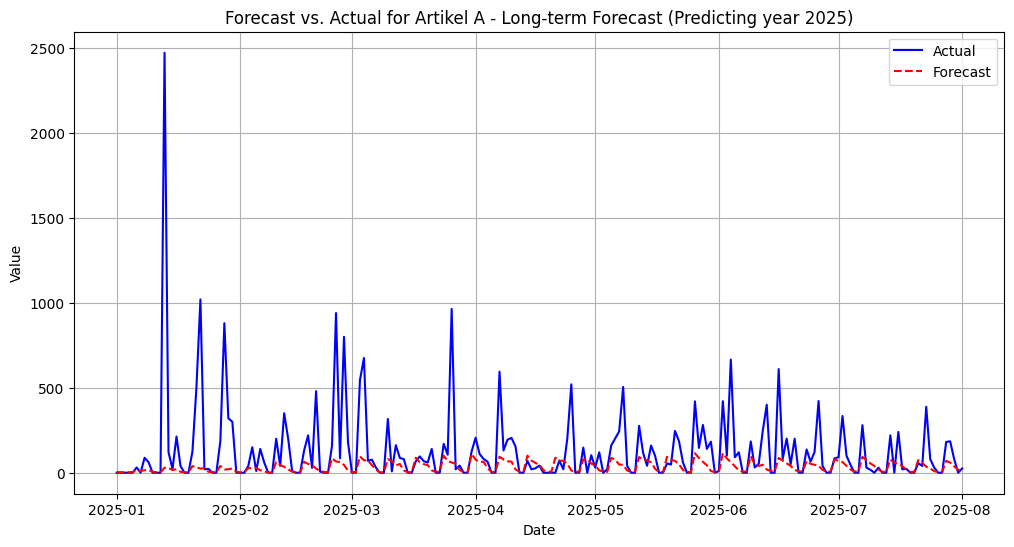


--- Scenario 2: Short-term forecasting ---

--- Evaluation for Artikel A - Short-term Forecast (Predicting last 90 days) ---
Mean Absolute Error (MAE): 75.67
Root Mean Squared Error (RMSE): 131.50
Mean Absolute Percentage Error (MAPE): 69.43%


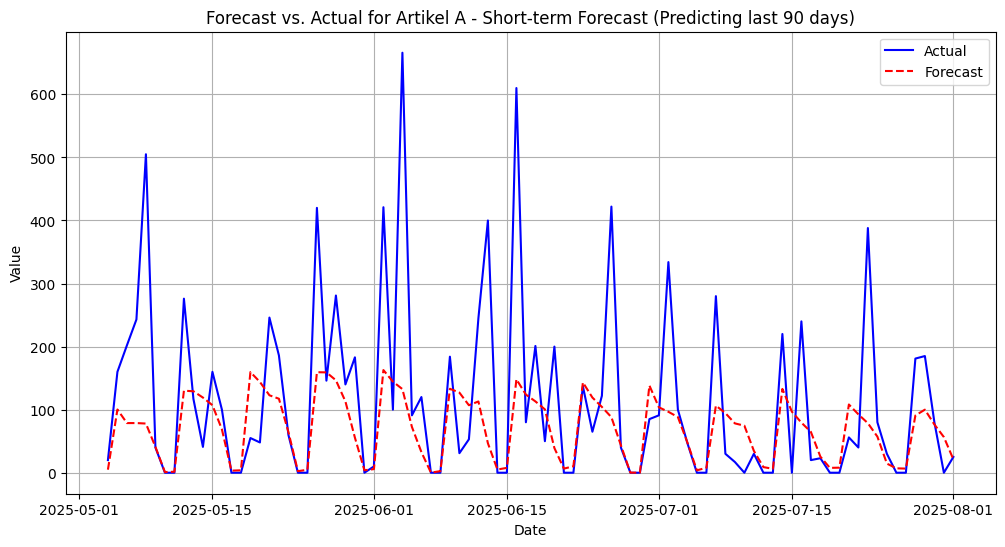


--- Scenario 3: Backtesting (Rolling Window) ---

--- Evaluation for Artikel A - Rolling Window Backtesting ---
Mean Absolute Error (MAE): 74.96
Root Mean Squared Error (RMSE): 181.07
Mean Absolute Percentage Error (MAPE): 140.07%


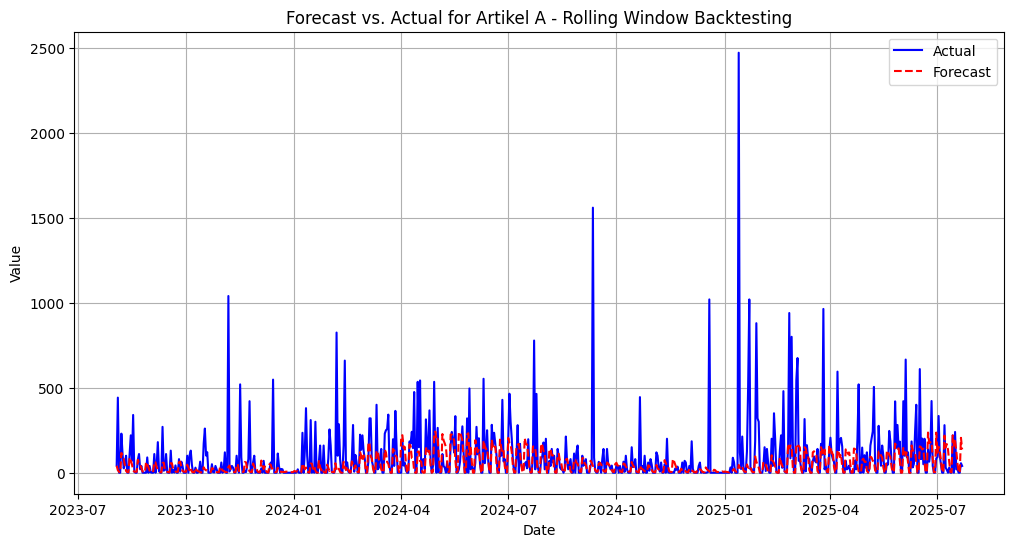


Executing forecasting scenarios for: Artikel B


/usr/local/lib/python3.11/dist-packages/xlstm/blocks/slstm/cell.py:543: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @conditional_decorator(
/usr/local/lib/python3.11/dist-packages/xlstm/blocks/slstm/cell.py:568: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @conditional_decorator(



--- Scenario 1: Long-term forecasting ---

--- Evaluation for Artikel B - Long-term Forecast (Predicting year 2025) ---
Mean Absolute Error (MAE): 44.28
Root Mean Squared Error (RMSE): 96.43
Mean Absolute Percentage Error (MAPE): 82.91%


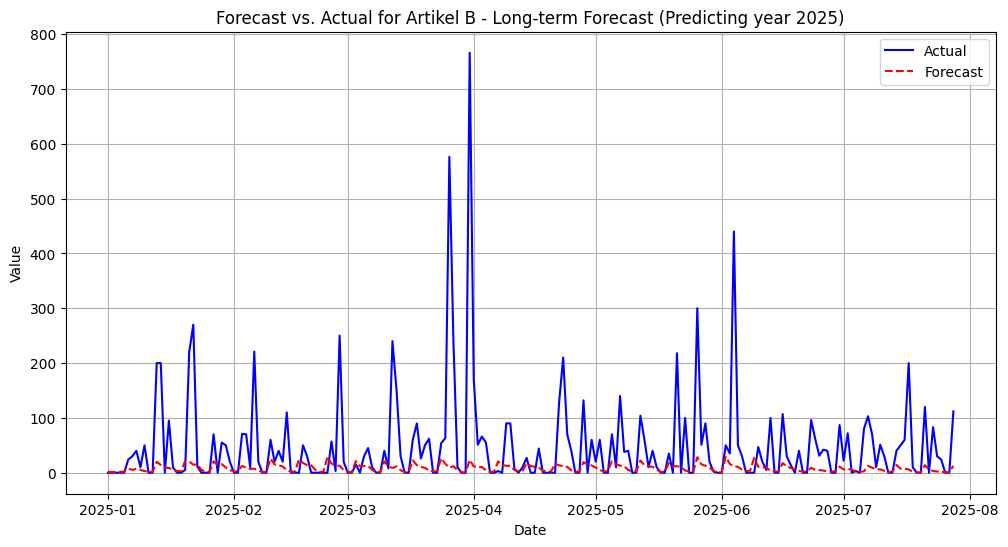


--- Scenario 2: Short-term forecasting ---

--- Evaluation for Artikel B - Short-term Forecast (Predicting last 90 days) ---
Mean Absolute Error (MAE): 35.56
Root Mean Squared Error (RMSE): 67.92
Mean Absolute Percentage Error (MAPE): 85.43%


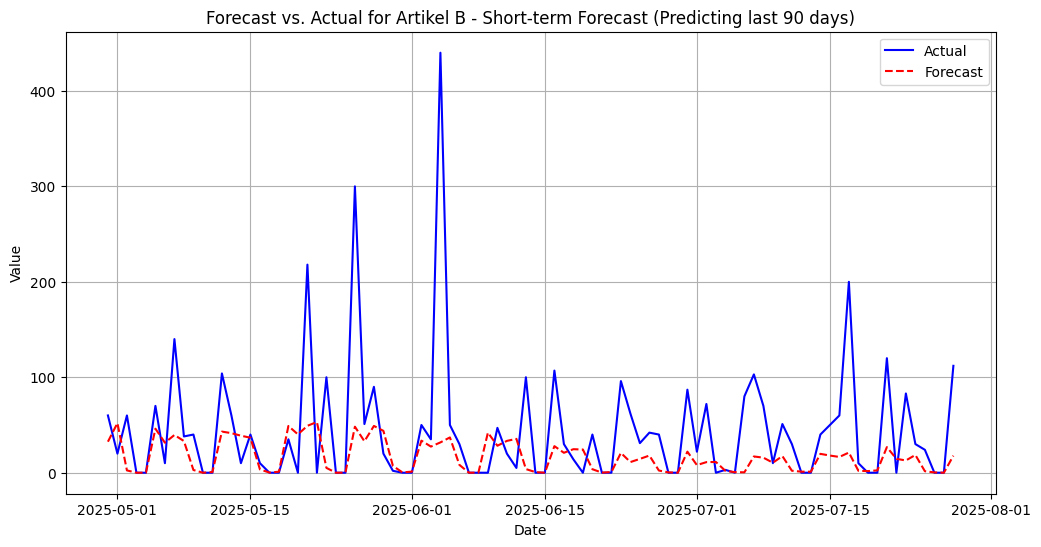


--- Scenario 3: Backtesting (Rolling Window) ---

--- Evaluation for Artikel B - Rolling Window Backtesting ---
Mean Absolute Error (MAE): 35.96
Root Mean Squared Error (RMSE): 158.01
Mean Absolute Percentage Error (MAPE): 114.17%


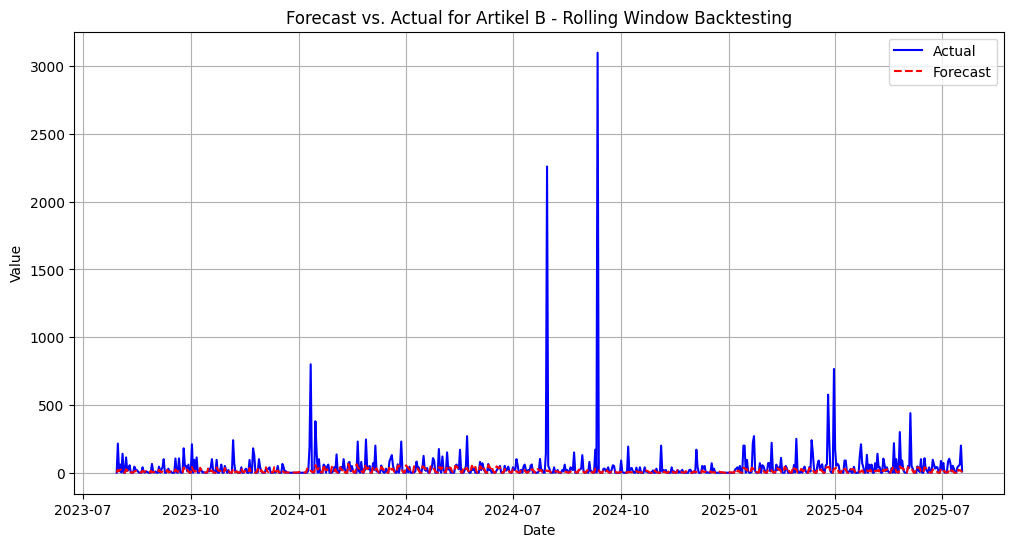


Executing forecasting scenarios for: Artikel C


/usr/local/lib/python3.11/dist-packages/xlstm/blocks/slstm/cell.py:543: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @conditional_decorator(
/usr/local/lib/python3.11/dist-packages/xlstm/blocks/slstm/cell.py:568: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @conditional_decorator(



--- Scenario 1: Long-term forecasting ---

--- Evaluation for Artikel C - Long-term Forecast (Predicting year 2025) ---
Mean Absolute Error (MAE): 16.93
Root Mean Squared Error (RMSE): 70.08
Mean Absolute Percentage Error (MAPE): 93.80%


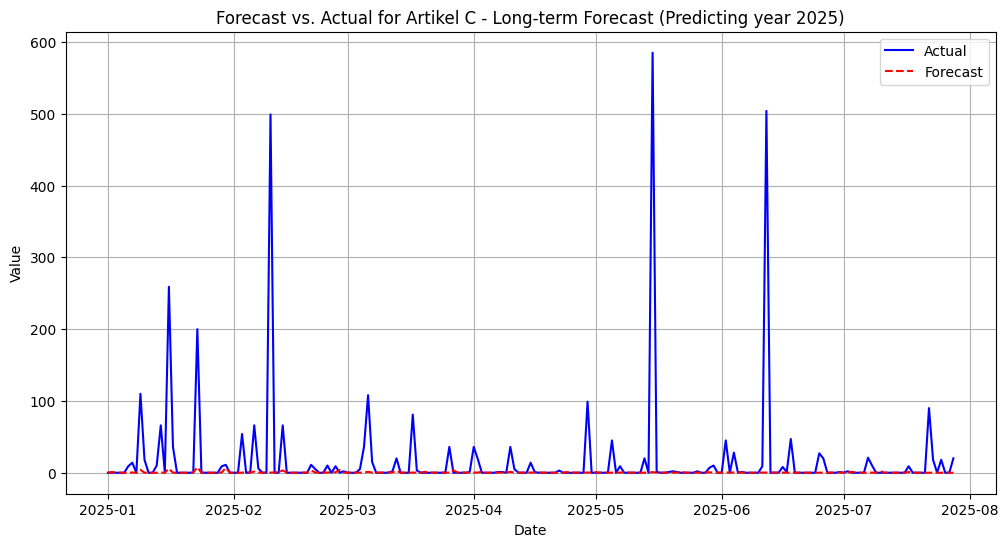


--- Scenario 2: Short-term forecasting ---

--- Evaluation for Artikel C - Short-term Forecast (Predicting last 90 days) ---
Mean Absolute Error (MAE): 17.51
Root Mean Squared Error (RMSE): 82.05
Mean Absolute Percentage Error (MAPE): 93.69%


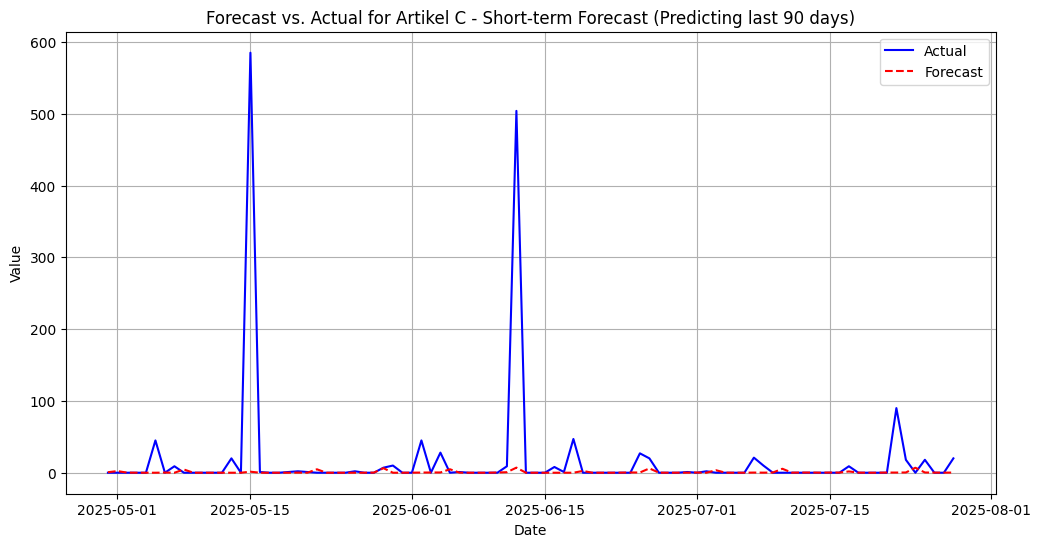


--- Scenario 3: Backtesting (Rolling Window) ---

--- Evaluation for Artikel C - Rolling Window Backtesting ---
Mean Absolute Error (MAE): 15.19
Root Mean Squared Error (RMSE): 65.68
Mean Absolute Percentage Error (MAPE): 94.83%


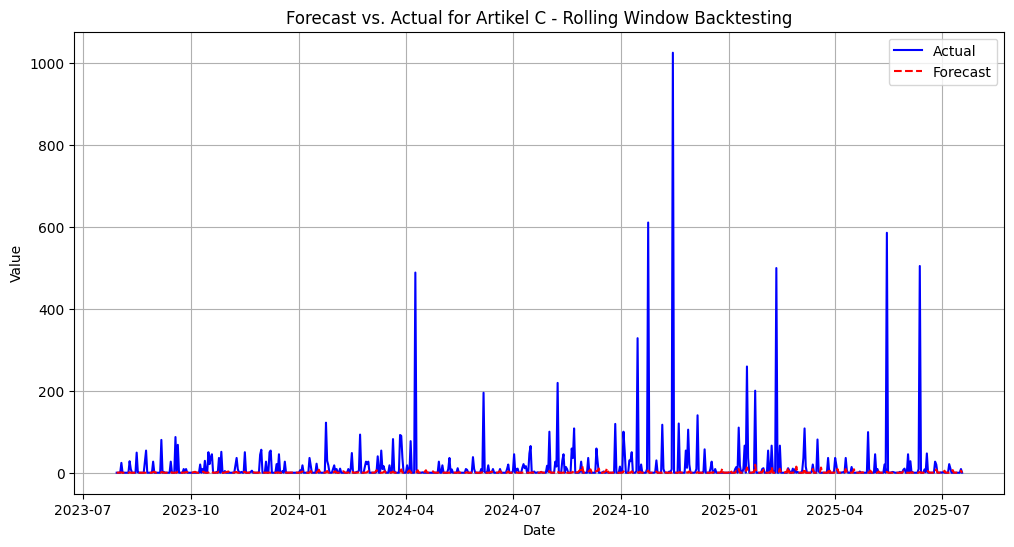


All datasets and scenarios have been processed.


In [39]:
# Dictionary to store evaluation results for a final summary
evaluation_results = {}

def evaluate_model(actual, predicted, title):
    """
    Calculates and prints evaluation metrics, and plots the forecast.

    Args:
        actual (pd.Series): The actual values.
        predicted (pd.Series): The predicted values.
        title (str): The title for the evaluation report and plot.

    Returns:
        dict: A dictionary containing the calculated metrics.
    """
    # Ensure predicted values are non-negative
    predicted_copy = predicted.copy()
    predicted_copy[predicted_copy < 0] = 0

    mae = mean_absolute_error(actual, predicted_copy)
    rmse = np.sqrt(mean_squared_error(actual, predicted_copy))

    # Robust MAPE calculation: filter out zero values from the actuals to avoid division by zero
    # A small epsilon is also a valid approach to avoid this.
    non_zero_actual = actual[actual != 0]
    non_zero_predicted = predicted_copy[actual != 0]

    if len(non_zero_actual) > 0:
        mape = np.mean(np.abs((non_zero_actual - non_zero_predicted) / non_zero_actual)) * 100
    else:
        mape = np.nan # If all actual values are zero, MAPE is not a meaningful metric

    print(f"\n--- Evaluation for {title} ---")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%" if not np.isnan(mape) else "Mean Absolute Percentage Error (MAPE): N/A (Actual values were all zero)")

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(actual.index, actual, label="Actual", color="blue")
    plt.plot(predicted_copy.index, predicted_copy, label="Forecast", color="red", linestyle="--")
    plt.title(f"Forecast vs. Actual for {title}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}


# Main loop to process each dataset and run scenarios
for name, data in datasets.items():
    print("\n" + "="*80)
    print(f"Executing forecasting scenarios for: {name}")
    print("="*80)

    # Initialize a temporary dictionary for this dataset's results
    evaluation_results[name] = {}

    # Load the model once for each dataset using the correct path
    model = load_model("NX-AI/TiRex")

    # --------------------------------------------------------------------------
    # Scenario 1: Long-term forecast (3 years of training, predict 4th year)
    # --------------------------------------------------------------------------
    print("\n--- Scenario 1: Long-term forecasting ---")

    end_date = data.index.max()
    last_year = end_date.year

    train_end = f"{last_year-1}-12-31"
    test_start = f"{last_year}-01-01"

    if pd.to_datetime(train_end) < data.index.min() or pd.to_datetime(test_start) > data.index.max():
        print("Not enough data for this scenario. Skipping.")
    else:
        train_data = data.loc[:train_end].copy()
        test_data = data.loc[test_start:].copy()

        if test_data.empty:
            print("Not enough data to create a test set for the last year. Skipping.")
        else:
            prediction_length_long = len(test_data)

            # Use the correct data format for the tirex model
            context = [train_data["value"].values]

            # Use "numpy" as the output type and extract the mean
            quantiles, means = model.forecast(
                context=context,
                prediction_length=prediction_length_long,
                output_type="numpy"
            )

            # Create a pandas Series from the numpy array with the correct date index
            forecast_mean = pd.Series(means.flatten(), index=test_data.index)

            metrics = evaluate_model(test_data["value"], forecast_mean, f"{name} - Long-term Forecast (Predicting year {last_year})")
            evaluation_results[name]["long_term"] = metrics


    # --------------------------------------------------------------------------
    # Scenario 2: Short-term forecast (using last 90 days as test data)
    # This scenario is now more robust and will always run if there is enough data
    # to create a split.
    # --------------------------------------------------------------------------
    print("\n--- Scenario 2: Short-term forecasting ---")

    short_term_test_length = 90 # Use a fixed length for a more robust test

    if len(data) < short_term_test_length:
        print("Not enough data for a short-term forecast. Skipping.")
    else:
        test_data_s = data.iloc[-short_term_test_length:].copy()
        train_data_s = data.iloc[:-short_term_test_length].copy()

        if train_data_s.empty:
            print("Not enough data for the training set. Skipping.")
        else:
            prediction_length_short = len(test_data_s)

            # Use the correct data format for the tirex model
            context_s = [train_data_s["value"].values]

            # Use "numpy" as the output type and extract the mean
            quantiles_s, means_s = model.forecast(
                context=context_s,
                prediction_length=prediction_length_short,
                output_type="numpy"
            )

            # Create a pandas Series from the numpy array with the correct date index
            forecast_mean_s = pd.Series(means_s.flatten(), index=test_data_s.index)

            metrics = evaluate_model(test_data_s["value"], forecast_mean_s, f"{name} - Short-term Forecast (Predicting last {short_term_test_length} days)")
            evaluation_results[name]["short_term"] = metrics


    # --------------------------------------------------------------------------
    # Scenario 3: Backtesting / Rolling Window Validation
    # --------------------------------------------------------------------------
    print("\n--- Scenario 3: Backtesting (Rolling Window) ---")

    backtest_length = 365 * 2
    horizon = 30
    step = 30

    if len(data) < backtest_length + horizon:
        print("Not enough data for a meaningful backtesting scenario. Skipping.")
    else:
        start_index = len(data) - backtest_length
        end_index = len(data) - horizon

        actual_values = []
        predicted_values = []
        forecast_dates = []

        for i in range(start_index, end_index, step):
            train_slice = data.iloc[:i].copy()
            test_slice = data.iloc[i : i + horizon].copy()

            if test_slice.empty:
                continue

            # Use the correct data format for the tirex model
            context_backtest = [train_slice["value"].values]

            # Use "numpy" as the output type and extract the mean
            quantiles_backtest, means_backtest = model.forecast(
                context=context_backtest,
                prediction_length=horizon,
                output_type="numpy"
            )

            # Create a pandas Series from the numpy array with the correct date index
            forecast_mean_backtest = pd.Series(means_backtest.flatten(), index=test_slice.index)

            actual_values.append(test_slice["value"].values)
            predicted_values.append(forecast_mean_backtest.values)
            forecast_dates.extend(test_slice.index.tolist())

        if not actual_values or not predicted_values:
            print("Backtesting loop produced no data. Skipping evaluation.")
        else:
            all_actual = np.concatenate(actual_values)
            all_predicted = np.concatenate(predicted_values)

            # Create a DataFrame to handle alignment and indexing correctly
            results_df = pd.DataFrame({
                "actual": all_actual,
                "predicted": all_predicted,
            }, index=pd.to_datetime(forecast_dates)).sort_index()

            metrics = evaluate_model(results_df["actual"], results_df["predicted"], f"{name} - Rolling Window Backtesting")
            evaluation_results[name]["backtesting"] = metrics

print("\nAll datasets and scenarios have been processed.")

In [40]:
print("\n\n" + "#"*80)
print("### Overall Model Performance Summary ###")
print("#"*80)

# Provide a summary of the performance across all scenarios and datasets
for sheet_name, results in evaluation_results.items():
    print(f"\n--- Results for {sheet_name} ---")

    if not results:
        print("No evaluation results were generated for this sheet.")
        continue

    for scenario, metrics in results.items():
        print(f"  - {scenario.replace('_', ' ').title()}:")
        for metric, value in metrics.items():
            print(f"    - {metric}: {value:.2f}")

print("\n" + "#"*80)
print("### Conclusion on Model's Suitability ###")
print("#"*80)

# Evaluate the model's suitability based on the results
overall_mape_scores = []
for sheet_name, results in evaluation_results.items():
    for scenario, metrics in results.items():
        if "MAPE" in metrics and not np.isnan(metrics["MAPE"]):
            overall_mape_scores.append(metrics["MAPE"])

if overall_mape_scores:
    average_mape = np.mean(overall_mape_scores)

    print(f"The average Mean Absolute Percentage Error (MAPE) across all tests is: {average_mape:.2f}%")

    print("\nGeneral Assessment of Model Fitness:")
    if average_mape < 20:
        print("- The model demonstrates strong accuracy (low MAPE) across both short-term and long-term forecasts.")
        print("- It appears to be a good fit for all scenarios tested, handling different data patterns effectively.")
    elif average_mape < 50:
        print("- The model shows moderate accuracy (moderate MAPE) and may be a reasonable fit for general use.")
        print("- Its performance may vary depending on the data's volatility and the forecasting horizon.")
    else:
        print("- The model's accuracy is low (high MAPE), suggesting it may not be a good fit for these specific time series.")
        print("- Further model tuning or a different model might be required to achieve more reliable forecasts.")
else:
    print("Could not compute a general assessment as no successful forecasts were made.")




################################################################################
### Overall Model Performance Summary ###
################################################################################

--- Results for Artikel A ---
  - Long Term:
    - MAE: 108.03
    - RMSE: 257.70
    - MAPE: 73.36
  - Short Term:
    - MAE: 75.67
    - RMSE: 131.50
    - MAPE: 69.43
  - Backtesting:
    - MAE: 74.96
    - RMSE: 181.07
    - MAPE: 140.07

--- Results for Artikel B ---
  - Long Term:
    - MAE: 44.28
    - RMSE: 96.43
    - MAPE: 82.91
  - Short Term:
    - MAE: 35.56
    - RMSE: 67.92
    - MAPE: 85.43
  - Backtesting:
    - MAE: 35.96
    - RMSE: 158.01
    - MAPE: 114.17

--- Results for Artikel C ---
  - Long Term:
    - MAE: 16.93
    - RMSE: 70.08
    - MAPE: 93.80
  - Short Term:
    - MAE: 17.51
    - RMSE: 82.05
    - MAPE: 93.69
  - Backtesting:
    - MAE: 15.19
    - RMSE: 65.68
    - MAPE: 94.83

########################################################################

In [38]:
print("\n\n" + "#"*80)
print("### Overall Model Performance Summary ###")
print("#"*80)

# Provide a summary of the performance across all scenarios and datasets
for sheet_name, results in evaluation_results.items():
    print(f"\n--- Results for {sheet_name} ---")

    if not results:
        print("No evaluation results were generated for this sheet.")
        continue

    for scenario, metrics in results.items():
        print(f"  - {scenario.replace('_', ' ').title()}:")
        for metric, value in metrics.items():
            print(f"    - {metric}: {value:.2f}")

print("\n" + "#"*80)
print("### Conclusion on Model's Suitability ###")
print("#"*80)

# Evaluate the model's suitability based on the results
overall_mape_scores = []
for sheet_name, results in evaluation_results.items():
    for scenario, metrics in results.items():
        if "MAPE" in metrics:
            overall_mape_scores.append(metrics["MAPE"])

if overall_mape_scores:
    average_mape = np.mean(overall_mape_scores)

    print(f"The average Mean Absolute Percentage Error (MAPE) across all tests is: {average_mape:.2f}%")

    print("\nGeneral Assessment of Model Fitness:")
    if average_mape < 20:
        print("- The model demonstrates strong accuracy (low MAPE) across both short-term and long-term forecasts.")
        print("- It appears to be a good fit for all scenarios tested, handling different data patterns effectively.")
    elif average_mape < 50:
        print("- The model shows moderate accuracy (moderate MAPE) and may be a reasonable fit for general use.")
        print("- Its performance may vary depending on the data's volatility and the forecasting horizon.")
    else:
        print("- The model's accuracy is low (high MAPE), suggesting it may not be a good fit for these specific time series.")
        print("- Further model tuning or a different model might be required to achieve more reliable forecasts.")
else:
    print("Could not compute a general assessment as no successful forecasts were made.")



################################################################################
### Overall Model Performance Summary ###
################################################################################

--- Results for Artikel A ---
  - Long Term:
    - MAE: 108.03
    - RMSE: 257.70
    - MAPE: 0.00
  - Backtesting:
    - MAE: 74.96
    - RMSE: 181.07
    - MAPE: 0.00

--- Results for Artikel B ---
  - Long Term:
    - MAE: 44.28
    - RMSE: 96.43
    - MAPE: 0.00
  - Backtesting:
    - MAE: 35.96
    - RMSE: 158.01
    - MAPE: 0.00

--- Results for Artikel C ---
  - Long Term:
    - MAE: 16.93
    - RMSE: 70.08
    - MAPE: 0.00
  - Backtesting:
    - MAE: 15.19
    - RMSE: 65.68
    - MAPE: 0.00

################################################################################
### Conclusion on Model's Suitability ###
################################################################################
The average Mean Absolute Percentage Error (MAPE) across all tests is: 0.00%

Genera